# Machine Learning Engineer Nanodegree

## Capstone Project

Porfirio Basaldua Gonzalez<br>April 3rd, 2023

### I. Project Overview

Can patient healthcare records predict the likelihood of mortality in an emergency room visit?

Solution statement

Machine Learning models combined with large amounts of data are well suited for prediction problems, and cloud infrastructure will ensure the system has enough resources to handle big-data concerns effectively. With this information, the proposed solution is as follows:

Using cloud infrastructure, the researcher will create a data pipeline that will expose an API through the internet which will allow the healthcare professionals to access real time predictions from a machine learning model. This predictions will indicate if the patient is likely to die while in emergency care, giving health care professionals a tool for decision making, shortening the time needed for the patient to receive adequate care.

## II. Analysis

### Data Exploration

#### Preparation
Install the necessary dependencies, import the libraries that will be used throughout the project and get the data from the S3 bucket that contains the initial CSV

In [3]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 14.1 MB/s eta 0:00:00


In [4]:
#General dependencies
import sagemaker
import pandas as pd
import boto3
import os
import seaborn as sns

#Data preprocessing
from io import StringIO
from category_encoders import BinaryEncoder

#Model training and hyperparameter tuning
from sagemaker.estimator import Estimator
from sagemaker.pytorch import PyTorch 
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, \
    HyperparameterTuner
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

In [6]:
#plot the figures as an output of the notebook cell
%matplotlib inline 

In [7]:
#Prepare commonly used objects
session = sagemaker.session.Session()
bucket = session.default_bucket()
s3_client = boto3.client('s3')
role = sagemaker.get_execution_role()

In [8]:
response = s3_client.get_object(Bucket=bucket, Key='data/data.csv')
body=response['Body']

In [9]:
#Import dataset from s3
data = body.read().decode('utf-8')
df = pd.read_csv(StringIO(data))

/tmp/ipykernel_5923/285887691.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(data))


#### Initial analysis
Examples of the rows can be seen, where there are a lot of missing values, and there is a mixture of numerical and text-based features in the dataframe. The next sections will provide insight into what is needed to prepare the data to be used as input for the LightGBM model.

In [7]:
df.head()

,deceased,subject_id,gender,race,arrival_transport,existing_doses,medicine_dispensations,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,0,14188788,1,OTHER,AMBULANCE,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,19659841,1,OTHER,AMBULANCE,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,11074777,1,WHITE,WALK IN,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,11075647,0,WHITE,WALK IN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,11858930,1,WHITE,HELICOPTER,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205504 entries, 0 to 205503
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   deceased                205504 non-null  int64  
 1   subject_id              205504 non-null  int64  
 2   gender                  205504 non-null  int64  
 3   race                    205504 non-null  object 
 4   arrival_transport       205504 non-null  object 
 5   existing_doses          205504 non-null  int64  
 6   medicine_dispensations  205504 non-null  int64  
 7   temperature             191025 non-null  float64
 8   heartrate               194174 non-null  float64
 9   resprate                192573 non-null  float64
 10  o2sat                   192534 non-null  float64
 11  sbp                     193632 non-null  float64
 12  dbp                     193241 non-null  float64
 13  pain                    197462 non-null  object 
 14  acuity              

In [9]:
for column in df.columns:
    print(column)
    missing_values = df[column].isna().sum()
    print(f'Missing values: {missing_values}')
    print(f'Percentage missing values: {missing_values / len(df[column]) : .2%}', '\n')

deceased
Missing values: 0
Percentage missing values:  0.00% 

subject_id
Missing values: 0
Percentage missing values:  0.00% 

gender
Missing values: 0
Percentage missing values:  0.00% 

race
Missing values: 0
Percentage missing values:  0.00% 

arrival_transport
Missing values: 0
Percentage missing values:  0.00% 

existing_doses
Missing values: 0
Percentage missing values:  0.00% 

medicine_dispensations
Missing values: 0
Percentage missing values:  0.00% 

temperature
Missing values: 14479
Percentage missing values:  7.05% 

heartrate
Missing values: 11330
Percentage missing values:  5.51% 

resprate
Missing values: 12931
Percentage missing values:  6.29% 

o2sat
Missing values: 12970
Percentage missing values:  6.31% 

sbp
Missing values: 11872
Percentage missing values:  5.78% 

dbp
Missing values: 12263
Percentage missing values:  5.97% 

pain
Missing values: 8042
Percentage missing values:  3.91% 

acuity
Missing values: 5076
Percentage missing values:  2.47% 



#### Exploring numerical columns
This table shows that the numerical features have extremely large maximum values, perhaps due to errors when registering the data. All of these values have to be deleted in order for the model to perform correctly.

In [12]:
column_list=['existing_doses','medicine_dispensations','temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
df[column_list].describe()

,existing_doses,medicine_dispensations,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
count,205504.000000,205504.000000,191025.000000,194174.000000,192573.000000,192534.000000,193632.000000,193241.000000,200428.000000
mean,14.536661,7.717869,98.026788,84.680572,17.414518,98.535019,135.276324,79.803498,2.627038
std,50.213646,19.452057,4.295442,17.956342,2.461268,9.550241,347.338749,154.066896,0.726921
min,0.000000,0.000000,0.300000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,1.000000,97.600000,72.000000,16.000000,98.000000,120.000000,69.000000,2.000000
50%,3.000000,3.000000,98.000000,83.000000,18.000000,99.000000,132.000000,78.000000,3.000000
75%,12.000000,8.000000,98.600000,95.000000,18.000000,100.000000,147.000000,87.000000,3.000000
max,3958.000000,1437.000000,986.000000,1109.000000,209.000000,2100.000000,151103.000000,51989.000000,5.000000


#### Exploring categorical variables
For the text-based columns, these analysis shows the different values that they contain. It is shown that the `pain` column has different values that what is described in the column definition

In [9]:
for column in ['race','arrival_transport', 'pain']:
    print(df[column].value_counts())

WHITE                                        118962
BLACK/AFRICAN AMERICAN                        25677
OTHER                                         11875
UNKNOWN                                        6409
ASIAN                                          4955
HISPANIC/LATINO - PUERTO RICAN                 4623
WHITE - OTHER EUROPEAN                         4512
ASIAN - CHINESE                                4159
HISPANIC/LATINO - DOMINICAN                    3225
BLACK/CAPE VERDEAN                             2789
BLACK/AFRICAN                                  2405
WHITE - RUSSIAN                                2213
BLACK/CARIBBEAN ISLAND                         1667
HISPANIC OR LATINO                             1328
HISPANIC/LATINO - GUATEMALAN                   1070
ASIAN - ASIAN INDIAN                            903
ASIAN - SOUTH EAST ASIAN                        861
WHITE - BRAZILIAN                               854
HISPANIC/LATINO - MEXICAN                       694
HISPANIC/LAT

In [11]:
print(df['pain'].unique())

[nan '&' ')' '+' '-' '.' '0' 0 1 2 3 4 5 6 '6' '7' '8' '9' '?' 'C' 'T' 'U'
 'c' 'i' 'o' 's' 't' 'u' ' 0' ' 4' ' 6' ' c' '++' '-0' '.0' '.3' '.5' '/?'
 '0 ' '0-' '0.' '0/' '00' '01' '03' '06' '07' '08' '09' '10' '11' '12'
 '13' '14' '15' '16' '18' '19' '2,' '2.' '20' '23' '3 ' '3t' '5 ' '51'
 '54' '56' '6 ' '61' '68' '6`' '7/' '70' '73' '75' '8 ' '8,' '8.' '8/'
 '88' '9 ' '9+' '90' '95' '97' '98' '<1' '?/' '??' 'CP' 'RA' 'UA' 'Ua'
 'na' 'no' 'o3' 'ok' 'ph' 'ra' 'uA' 'ua' 'un' 'ut' ' 10' '0  ' '0, ' '0-1'
 '0-2' '0-5' '0-7' '0-8' '0-9' '0..' '0.5' '069' '1 0' '1-2' '1-3' '1-7'
 '1.2' '1.5' '1/2' '10 ' '10+' '10.' '10/' '100' '134' '180' '1`0' '2-3'
 '2-4' '2-6' '2-7' '2-8' '2-9' '2. ' '2.5' '3  ' '3-4' '3-5' '3-6' '3-7'
 '3.5' '4-5' '4-8' '4. ' '4.5' '4/9' '5-6' '5-8' '5-9' '5.5' '5.8' '5/7'
 '5/8' '5/9' '6-7' '6-8' '6-9' '6.5' '7-6' '7-8' '7-9' '7.5' '7/8' '8  '
 '8-9' '8.5' '8.6' '8.7' '8/6' '8/9' '9  ' '9-8' '9.4' '9.5' '9.7' '9.9'
 '9/6' '>10' 'AMS' 'Bad' 'ETT' 'INT' 'NAD' 'Pt ' 'Ref

### Exploratory Visualization

The following plot demostrates the skew of the target column, where the majority of the patients survived the ED visit.

<AxesSubplot:xlabel='deceased', ylabel='count'>

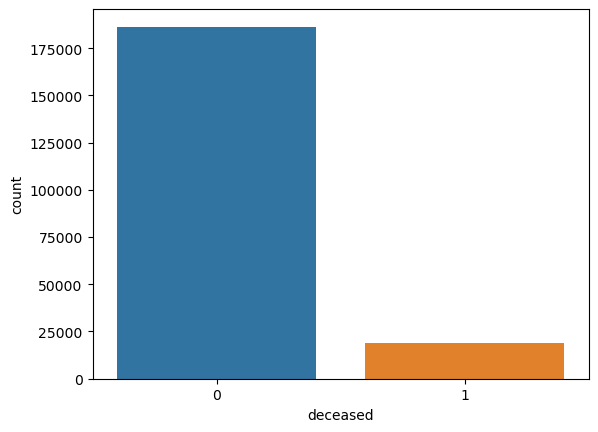

In [10]:
sns.countplot(x=df['deceased'])

## III. Methodology

### Data Preprocessing

This section addresses the abnormaalities identified in the previous section. At the end, a cleaned dataframe will be stoored in S3 for the use of training and refinement processes.

Drop unused columns

In [13]:
df = df.drop(axis=1, columns=['subject_id', 'pain'])

Drop null values

In [14]:
df = df.dropna()

Encode categorical variables

In [13]:
dummies = pd.get_dummies(df['arrival_transport'], prefix='arrival_transport', drop_first=True)
df = df.join(dummies)
df = df.drop('arrival_transport', axis=1)


df = BinaryEncoder(cols=['race'], drop_invariant=True).fit_transform(df)

''

Scale these two columns

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[ ['existing_doses', 'medicine_dispensations'] ] = scaler.fit_transform(
    df[ ['existing_doses', 'medicine_dispensations'] ])

Drop erroneous readings

In [17]:
# sbp - drop values higher than 300 (even then, these are extreme)
# dbp - drop values higher than 300 (even then, these are extreme)
df = df[ (df['sbp'] <= 300) & (df['dbp'] <= 300) ]

Define column types

In [18]:
int_columns=['race_0','race_1','race_2','race_3','race_4','race_5','arrival_transport_HELICOPTER',
            'arrival_transport_OTHER','arrival_transport_UNKNOWN','arrival_transport_WALK IN']
float_columns=['existing_doses','medicine_dispensations','temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
df['deceased']=df['deceased'].astype('bool')
df[int_columns]=df[int_columns].astype('int')
df[float_columns]=df[float_columns].astype('float')

#### Overview of the cleaned dataframe
It can be seen that the resulting dataset has a low number of columns, and that the number of samples is low as well. Both of these characteristics improve the performance of the LightGBM model

In [19]:
#Overview of the cleaned dataset
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186540 entries, 6267 to 205503
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   deceased                      186540 non-null  bool   
 1   gender                        186540 non-null  int64  
 2   race_0                        186540 non-null  int64  
 3   race_1                        186540 non-null  int64  
 4   race_2                        186540 non-null  int64  
 5   race_3                        186540 non-null  int64  
 6   race_4                        186540 non-null  int64  
 7   race_5                        186540 non-null  int64  
 8   existing_doses                186540 non-null  float64
 9   medicine_dispensations        186540 non-null  float64
 10  temperature                   186540 non-null  float64
 11  heartrate                     186540 non-null  float64
 12  resprate                      186540 non-

Save the corrected dataframe to s3

In [55]:
file_name='cleaned_data.csv'
s3_prefix='data'
object_name=os.path.join(s3_prefix, file_name)
#Create csv from cleaned dataframe
df.to_csv(file_name,index=False)
#Save csv on s3 bucket
try:
    response = s3_client.upload_file(file_name, bucket, object_name)
except ClientError as e:
    print(e)

### Refinement

#### Hyperparameter tuning
This section is completed before the model training, in order to be able to train a model with the optimal combination of parameters.

In [56]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-4, 1, scaling_type="Logarithmic"),
    "num_iterations": IntegerParameter(2, 30),
    "early_stopping_rounds": IntegerParameter(2, 30),
    "num_leaves": IntegerParameter(10, 50),
    "max_depth": IntegerParameter(5, 30),
}
objective_metric_name = "Test Accuracy"
objective_type="Maximize"
metric_definitions=[{"Name": "Test Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

Download the predefined, specialized training image for the LightGBM model

In [57]:
# Currently, not all the object detection models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.

train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

#Looking at the example project
# print(train_source_uri)
# response = s3_client.get_object(Bucket='jumpstart-cache-prod-us-east-1', Key='source-directory-tarballs/lightgbm/transfer_learning/classification/v2.1.1/sourcedir.tar.gz')
# body=response['Body']
# with open('sourcedir.tar.gz','wb') as f:
#     f.write(body.read())

In [62]:
estimator = Estimator(
    role=role,
    image_uri=train_image_uri,
    source_dir="code/",
    entry_point="hpo.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    output_path='s3://'+bucket+'/hpo/'
)
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

In [25]:
base_path = os.path.join('s3://', bucket)
# os.environ['SM_CHANNEL_TRAINING']=os.path.join(base_path,'data')
# os.environ['SM_MODEL_DIR']=os.path.join(base_path,'model')
# os.environ['SM_OUTPUT_DATA_DIR']=os.path.join(base_path,'output')
#Setting varibles here doesnt affect the training (hyperparmeter tuning) environment. Research how to change default values

In [63]:
tuner.fit({"training": base_path}, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................!


Describe the tuning results

In [64]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230402-1939')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""1024""","""15""",0.001354,pytorch-training-230402-1939-002-4b5b409a,Completed,0.914841,2023-04-02 19:40:23+00:00,2023-04-02 19:42:25+00:00,122.0
1,"""1024""","""10""",0.033328,pytorch-training-230402-1939-001-e5e8c553,Completed,0.914841,2023-04-02 19:40:18+00:00,2023-04-02 19:42:26+00:00,128.0


In [65]:
#Get the hyperparameters of the best trained model
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-04-03 05:19:42 Starting - Preparing the instances for training
2023-04-03 05:19:42 Downloading - Downloading input data
2023-04-03 05:19:42 Training - Training image download completed. Training in progress.
2023-04-03 05:19:42 Uploading - Uploading generated training model
2023-04-03 05:19:42 Completed - Resource retained for reuse


{'_tuning_objective_metric': 'Test Accuracy',
 'early_stopping_rounds': '25',
 'learning_rate': '0.4921729293048727',
 'max_depth': '15',
 'num_iterations': '29',
 'num_leaves': '10',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"pytorch-training-2023-04-03-05-16-20-121"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-927441871693/pytorch-training-2023-04-03-05-16-20-121/source/sourcedir.tar.gz"'}

### Implementation

Once the best hyperparameters are selected, the model is traine once withe these optimal configuration, and an endpoint is deployed. This endpoint copies the trained model to serve predictions with an API

In [22]:
best_hyperparameters = {
    'early_stopping_rounds': '25',
    'learning_rate': '0.4921729293048727',
    'max_depth': '15',
    'num_iterations': '29',
    'num_leaves': '10',
}

In [68]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

In [23]:
deploy_estimator = PyTorch(
    entry_point="train_and_deploy.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="1.12.0",
    py_version='py38',
    source_dir='code/',
    hyperparameters=best_hyperparameters,
)

In [26]:
deploy_estimator.fit({"training": base_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-03-14-34-56-234


2023-04-03 14:35:33 Starting - Starting the training job...
2023-04-03 14:35:51 Starting - Preparing the instances for training......
2023-04-03 14:37:03 Downloading - Downloading input data
2023-04-03 14:37:03 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-03 14:37:46,382 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-03 14:37:46,384 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-03 14:37:46,391 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-03 14:37:46,393 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-03 14:37:47,987 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [27]:
predictor = deploy_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

INFO:sagemaker:Creating model with name: pytorch-training-2023-04-03-14-47-56-259
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-04-03-14-47-56-259
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-04-03-14-47-56-259


------!

In [32]:
#Randomly select a sample (row) from the entire dataset, and make a prediction
# import torch
test_sample = df.sample()
# tensors = torch.tensor(test_sample.to_numpy())
response = predictor.predict(test_sample.drop(columns='deceased'))

# tensors = torch.tensor(test_sample.to_numpy())
    # prediction = retreived_model.predict(tensors)
print(response)

[0]


In [37]:
print(f'''The correct label was: {test_sample['deceased']}. The predicted label was: {bool(response[0])}''')

The correct label was: 137500    False
Name: deceased, dtype: bool. The predicted label was: False


## IV. Results

### Model Evaluation and Validation

The accuracy was 91.4%, being lower than the benchmark metric of 93.6%. These numbers can be compared directly, since the authors of the research paper used the same model  and dataset as this project.
The performance of the model developed here was inferior to the benchmark, but the difference is 2% of the benchmark value, which points to a satisfactory performance of the model developed in this project.
Perhaps the difference is explained by the feature engineering that was done in this project, and the limitation of the data that was considered for this project.